In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from os.path import join, dirname, exists, isdir, isfile, splitext, basename
from os import listdir
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

In [2]:
path = "/Users/jonathanraiman/Desktop/cases/"

In [3]:
def find_pairs(path):
    if isdir(path):
        children = [join(path, fname) for fname in listdir(path)]
        files = [subpath for subpath in children if isfile(subpath)]
        dirs = [subpath for subpath in children if isdir(subpath)]
        if len(files) > 0:
            return {path: files}
        else:
            out = {}
            for subpath in dirs:
                out.update(find_pairs(subpath))
            return out
    return {}

In [4]:
from raive.image_embedding.image_embedder import ImageEmbedder
from raive.constants import CLIP_IMAGE_EMBEDDING_VERSION
from raive.torch_utils import auto_device

In [5]:
from transformers import CLIPModel, CLIPVisionModel

In [7]:
embedder = ImageEmbedder(CLIP_IMAGE_EMBEDDING_VERSION, device=auto_device(), color_count=8)

In [8]:
pairs = find_pairs(path)

In [14]:
embedded_pairs = {}
for key, files in tqdm(pairs.items()):
    embeds = []
    for fname in files:
        embeds.append((fname, embedder.embed_image(Image.open(fname), compute_extras=False)))
    embedded_pairs[key] = embeds

  0%|          | 0/11 [00:00<?, ?it/s]

In [17]:
FU_SCORES = {}
NFU_SCORES = {}
OTHER_SCORES = []

for key, case in embedded_pairs.items():
    for name, embed in case:
        based = splitext(basename(name))[0].lower()
        if "original" in based:
            rest = based.split("original")[-1]
            if len(rest) > 0:
                original_index = int(rest)
            else:
                original_index = None
            comparisons = []
            if original_index is not None:
                for other_name, other_embed in case:
                    if f"inspired{original_index}" in basename(other_name).lower():
                        comparisons.append((other_name, other_embed))
            else:
                for other_name, other_embed in case:
                    if "inspired" in basename(other_name).lower():
                        comparisons.append((other_name, other_embed))
            assert len(comparisons) > 0          
            original_embed = embed.embedding / np.linalg.norm(embed.embedding)
            derived = [(image, embed.embedding / np.linalg.norm(embed.embedding)) for image, embed in comparisons]
            visited = set([image for image, _ in derived] + [name])
            for image, el in derived:
                score = original_embed.dot(el)
                if "not_fair_use" in image or "not fair use" in image.lower():
                    NFU_SCORES[image] = score
                else:
                    FU_SCORES[image] = score
            all_vecs = [embed.embedding
                        for _, other_case in embedded_pairs.items()
                        for image, embed in other_case if image not in visited]
            all_vecs = np.stack(all_vecs, axis=0)
            all_vecs = all_vecs / np.linalg.norm(all_vecs, axis=-1, keepdims=True)
            other_scores = original_embed.dot(all_vecs.T)
            OTHER_SCORES.extend(list(other_scores))
            

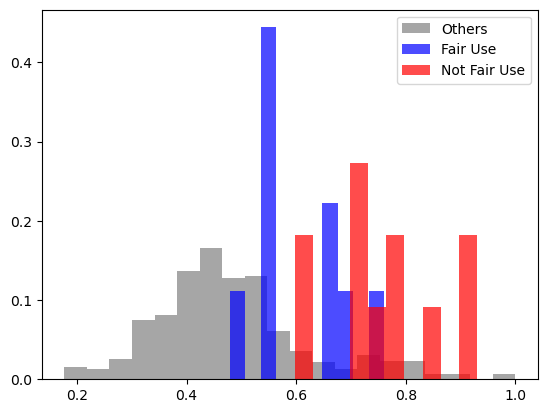

In [32]:
plt.hist(OTHER_SCORES, bins=20, color="gray", alpha=0.7,  density=False, label="Others", weights=np.ones(len(OTHER_SCORES)) / len(OTHER_SCORES))
plt.hist(FU_SCORES.values(), bins=10, color="blue", alpha=0.7,  density=False, label="Fair Use", weights=np.ones(len(FU_SCORES)) / len(FU_SCORES))
plt.hist(NFU_SCORES.values(),bins=10,  color="red", alpha=0.7,  density=False, label="Not Fair Use", weights=np.ones(len(NFU_SCORES)) / len(NFU_SCORES))
plt.legend();
plt.savefig("/Users/jonathanraiman/Desktop/fair_use.pdf", bbox_inches="tight");

In [29]:
for el, score in FU_SCORES.items():
    print(f'{el.split("/cases/")[-1].replace(" ", "_")}\t{score}')
for el, score in NFU_SCORES.items():
    print(f'{el.split("/cases/")[-1].replace(" ", "_")}\t{score}')

fair_use/FU_case2_(blanch_v_koons)/case2_inspired.jpg	0.6652143597602844
fair_use/FU_case3_(kienitz_v_sconnie_nation)/case3_inspired.jpg	0.47868579626083374
fair_use/FU_case1_(marano_v_met_museum)/case1_inspired.png	0.6696204543113708
fair_use/FU_case5_(cariou_v_prince)/these_images_were_deemed_fair_use/case5_inspired1.jpeg	0.5505673885345459
fair_use/FU_case5_(cariou_v_prince)/these_images_were_deemed_fair_use/case5_inspired2.jpeg	0.5401787161827087
fair_use/FU_case5_(cariou_v_prince)/these_images_were_deemed_fair_use/case5_inspired3.jpeg	0.5500699877738953
fair_use/FU_case5_(cariou_v_prince)/these_images_were_deemed_fair_use/case5_inspired4.jpeg	0.7604902982711792
fair_use/FU_case4_(green_day_v_seltzer)/case4_inspired1.jpg	0.6869364380836487
fair_use/FU_case4_(green_day_v_seltzer)/case4_inspired2.jpg	0.5370476841926575
fair_use/FU_case5_(cariou_v_prince)/these_images_were_deemed_PROBABLY_NOT_fair_use/NFU_case5_inspired3.jpeg	0.7762963771820068
fair_use/FU_case5_(cariou_v_prince)/thes